In [1]:
import numpy as np
import random
from ordered_set import OrderedSet
from datetime import datetime, timedelta

start_time = datetime.now().replace(microsecond=0)

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

np.random.seed(1990)
random.seed(1990)

# Generate transition model
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.005),
                                                          ConstantVelocity(0.005)])

yps = range(0, 100, 10)  # y value for prior state
truths = OrderedSet()
ntruths = 3  # number of ground truths in simulation
time_max = 50  # timestamps the simulation is observed over
timesteps = [start_time + timedelta(seconds=k) for k in range(time_max)]

xdirection = 1
ydirection = 1

# Generate ground truths
for j in range(0, ntruths):
    truth = GroundTruthPath([GroundTruthState([0, xdirection, yps[j], ydirection],
                                              timestamp=timesteps[0])], id=f"id{j}")

    for k in range(1, time_max):
        truth.append(
            GroundTruthState(transition_model.function(truth[k - 1], noise=True, time_interval=timedelta(seconds=1)),
                             timestamp=timesteps[k]))
    truths.add(truth)

    xdirection *= -1
    if j % 2 == 0:
        ydirection *= -1
        
from stonesoup.plotter import AnimatedPlotterly

# Stonesoup plotter requires sets not lists

plotter = AnimatedPlotterly(timesteps, tail_length=1)
plotter.plot_ground_truths(truths, [0, 2])
plotter.fig

In [6]:
total_no_sensors = 2

from stonesoup.types.state import StateVector
from stonesoup.sensor.radar.radar import RadarRotatingBearingRange
from stonesoup.types.angle import Angle

sensor_setA = set()
for n in range(0, total_no_sensors):
    sensor = RadarRotatingBearingRange(
        position_mapping=(0, 2),
        noise_covar=np.array([[np.radians(0.5) ** 2, 0],
                              [0, 1 ** 2]]),
        ndim_state=4,
        position=np.array([[10], [n * 50]]),
        rpm=60,
        fov_angle=np.radians(30),
        dwell_centre=StateVector([0.0]),
        max_range=np.inf,
        resolutions={'dwell_centre': Angle(np.radians(30))}
    )
    sensor_setA.add(sensor)
for sensor in sensor_setA:
    sensor.timestamp = start_time

sensor_setB = set()
for n in range(0, total_no_sensors):
    sensor = RadarRotatingBearingRange(
        position_mapping=(0, 2),
        noise_covar=np.array([[np.radians(0.5) ** 2, 0],
                              [0, 1 ** 2]]),
        ndim_state=4,
        position=np.array([[10], [n * 50]]),
        rpm=60,
        fov_angle=np.radians(30),
        dwell_centre=StateVector([0.0]),
        max_range=np.inf,
        resolutions={'dwell_centre': Angle(np.radians(30))}
    )
    sensor_setB.add(sensor)

for sensor in sensor_setB:
    sensor.timestamp = start_time
    
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

from stonesoup.updater.kalman import ExtendedKalmanUpdater
updater = ExtendedKalmanUpdater(measurement_model=None)
# measurement model is added to detections by the sensor

from stonesoup.types.state import GaussianState

priors = []
xdirection = 1.2
ydirection = 1.2
for j in range(0, ntruths):
    priors.append(GaussianState([[0], [xdirection], [yps[j]+0.1], [ydirection]],
                                np.diag([0.5, 0.5, 0.5, 0.5]+np.random.normal(0,5e-4,4)),
                                timestamp=start_time))
    xdirection *= -1
    if j % 2 == 0:
        ydirection *= -1
        
from stonesoup.types.track import Track

# Initialise tracks from the RandomSensorManager
tracksA = {Track([prior]) for prior in priors}

# Initialise tracks from the BruteForceSensorManager
tracksB = {Track([prior]) for prior in priors}

from stonesoup.sensormanager import RandomSensorManager
from stonesoup.sensormanager import BruteForceSensorManager
from stonesoup.sensormanager.reward import UncertaintyRewardFunction

randomsensormanager = RandomSensorManager(sensor_setA)

# initiate reward function
reward_function = UncertaintyRewardFunction(predictor, updater)

bruteforcesensormanager = BruteForceSensorManager(sensor_setB,
                                                  reward_function=reward_function)

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=5)

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
data_associator = GNNWith2DAssignment(hypothesiser)

from ordered_set import OrderedSet
from collections import defaultdict
import copy

sensor_history_A = defaultdict(dict)
for timestep in timesteps[1:]:

    # Generate chosen configuration
    chosen_actions = randomsensormanager.choose_actions(tracksA, timestep)

    # Create empty dictionary for measurements
    measurementsA = set()

    for chosen_action in chosen_actions:
        for sensor, actions in chosen_action.items():
            sensor.add_actions(actions)

    for sensor in sensor_setA:
        sensor.act(timestep)
        sensor_history_A[timestep][sensor] = copy.copy(sensor)

        # Observe this ground truth
        measurementsA |= sensor.measure(OrderedSet(truth[timestep] for truth in truths), noise=True)

    hypotheses = data_associator.associate(tracksA,
                                           measurementsA,
                                           timestep)
    for track in tracksA:
        hypothesis = hypotheses[track]
        if hypothesis.measurement:
            post = updater.update(hypothesis)
            track.append(post)
        else:  # When data associator says no detections are good enough, we'll keep the prediction
            track.append(hypothesis.prediction)
            
import plotly.graph_objects as go
from stonesoup.functions import pol2cart

plotterA = AnimatedPlotterly(timesteps, tail_length=1, sim_duration=10)
plotterA.plot_sensors(sensor_setA)
plotterA.plot_ground_truths(truths, [0, 2])
plotterA.plot_tracks(tracksA, [0, 2], uncertainty=True, plot_history=False)


def plot_sensor_fov(fig, sensor_set, sensor_history):
    # Plot sensor field of view
    trace_base = len(fig.data)
    for _ in sensor_set:
        fig.add_trace(go.Scatter(mode='lines',
                                 line=go.scatter.Line(color='black',
                                                      dash='dash')))

    for frame in fig.frames:
        traces_ = list(frame.traces)
        data_ = list(frame.data)

        timestring = frame.name
        timestamp = datetime.strptime(timestring, "%Y-%m-%d %H:%M:%S")

        for n, sensor_ in enumerate(sensor_set):
            x = [0, 0]
            y = [0, 0]

            if timestamp in sensor_history:
                sensor = sensor_history[timestamp][sensor_]
                for i, fov_side in enumerate((-1, 1)):
                    range_ = min(getattr(sensor, 'max_range', np.inf), 100)
                    x[i], y[i] = pol2cart(range_,
                                          sensor.dwell_centre[0, 0]
                                          + sensor.fov_angle / 2 * fov_side) \
                                 + sensor.position[[0, 1], 0]
            else:
                continue

            data_.append(go.Scatter(x=[x[0], sensor.position[0], x[1]],
                                    y=[y[0], sensor.position[1], y[1]],
                                    mode="lines",
                                    line=go.scatter.Line(color='black',
                                                         dash='dash'),
                                    showlegend=False))
            traces_.append(trace_base + n)

        frame.traces = traces_
        frame.data = data_


plot_sensor_fov(plotterA.fig, sensor_setA, sensor_history_A)
plotterA.fig

In [7]:
sensor_history_B = defaultdict(dict)
for timestep in timesteps[1:]:

    # Generate chosen configuration
    chosen_actions = bruteforcesensormanager.choose_actions(tracksB, timestep)

    # Create empty dictionary for measurements
    measurementsB = set()

    for chosen_action in chosen_actions:
        for sensor, actions in chosen_action.items():
            sensor.add_actions(actions)

    for sensor in sensor_setB:
        sensor.act(timestep)
        sensor_history_B[timestep][sensor] = copy.copy(sensor)

        # Observe this ground truth
        measurementsB |= sensor.measure(OrderedSet(truth[timestep] for truth in truths), noise=True)

    hypotheses = data_associator.associate(tracksB,
                                           measurementsB,
                                           timestep)
    for track in tracksB:
        hypothesis = hypotheses[track]
        if hypothesis.measurement:
            post = updater.update(hypothesis)
            track.append(post)
        else:  # When data associator says no detections are good enough, we'll keep the prediction
            track.append(hypothesis.prediction)

In [8]:
plotterB = AnimatedPlotterly(timesteps, tail_length=1, sim_duration=10)
plotterB.plot_sensors(sensor_setB)
plotterB.plot_ground_truths(truths, [0, 2])
plotterB.plot_tracks(tracksB, [0, 2], uncertainty=True, plot_history=False)
plot_sensor_fov(plotterB.fig, sensor_setB, sensor_history_B)
plotterB.fig

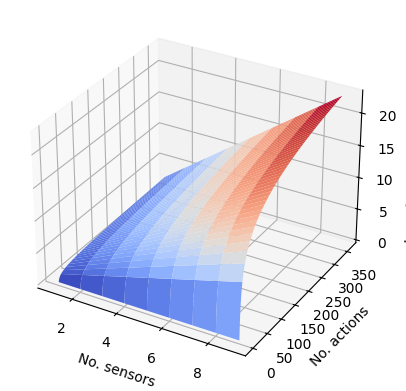

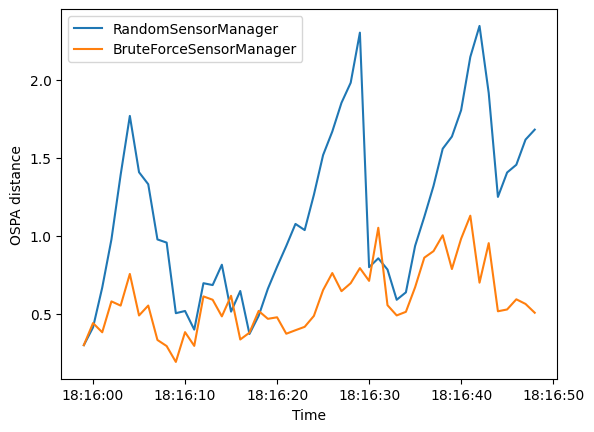

In [9]:
import matplotlib.pyplot as plt

nsensors = np.arange(1, 10)
nactions = np.arange(1, 360.0)
nsensors, nactions = np.meshgrid(nsensors, nactions)
ncombinations = nactions**nsensors

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(nsensors, nactions, np.log10(ncombinations), cmap='coolwarm')
ax.set_xlabel("No. sensors")
ax.set_ylabel("No. actions")
ax.set_zlabel("log of no. combinations")

from stonesoup.metricgenerator.ospametric import OSPAMetric
ospa_generator = OSPAMetric(c=40, p=1)

from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.measures import Euclidean
siap_generator = SIAPMetrics(position_measure=Euclidean((0, 2)),
                             velocity_measure=Euclidean((1, 3)))

from stonesoup.dataassociator.tracktotrack import TrackToTruth
associator = TrackToTruth(association_threshold=30)

from stonesoup.metricgenerator.uncertaintymetric import SumofCovarianceNormsMetric
uncertainty_generator = SumofCovarianceNormsMetric()

from stonesoup.metricgenerator.manager import SimpleManager

metric_managerA = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                associator=associator)

metric_managerB = SimpleManager([ospa_generator, siap_generator, uncertainty_generator],
                                associator=associator)

metric_managerA.add_data(truths, tracksA)
metric_managerB.add_data(truths, tracksB)

metricsA = metric_managerA.generate_metrics()
metricsB = metric_managerB.generate_metrics()

ospa_metricA = metricsA['OSPA distances']
ospa_metricB = metricsB['OSPA distances']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([i.timestamp for i in ospa_metricA.value],
        [i.value for i in ospa_metricA.value],
        label='RandomSensorManager')
ax.plot([i.timestamp for i in ospa_metricB.value],
        [i.value for i in ospa_metricB.value],
        label='BruteForceSensorManager')
ax.set_ylabel("OSPA distance")
ax.set_xlabel("Time")
ax.legend()

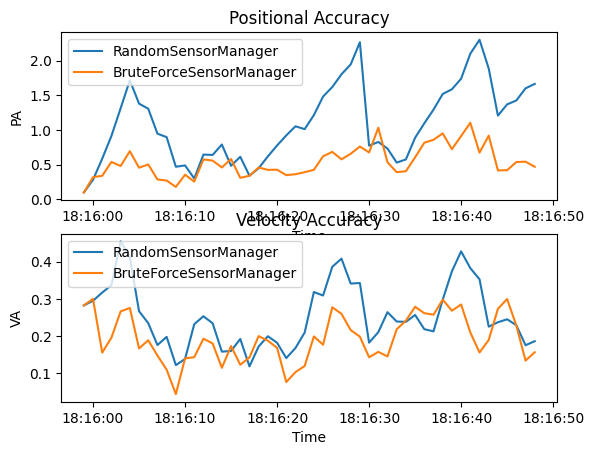

In [10]:
fig, axes = plt.subplots(2)

times = metric_managerA.list_timestamps()

pa_metricA = metricsA['SIAP Position Accuracy at times']
va_metricA = metricsA['SIAP Velocity Accuracy at times']

pa_metricB = metricsB['SIAP Position Accuracy at times']
va_metricB = metricsB['SIAP Velocity Accuracy at times']

axes[0].set(title='Positional Accuracy', xlabel='Time', ylabel='PA')
axes[0].plot(times, [metric.value for metric in pa_metricA.value],
             label='RandomSensorManager')
axes[0].plot(times, [metric.value for metric in pa_metricB.value],
             label='BruteForceSensorManager')
axes[0].legend()

axes[1].set(title='Velocity Accuracy', xlabel='Time', ylabel='VA')
axes[1].plot(times, [metric.value for metric in va_metricA.value],
             label='RandomSensorManager')
axes[1].plot(times, [metric.value for metric in va_metricB.value],
             label='BruteForceSensorManager')
axes[1].legend()

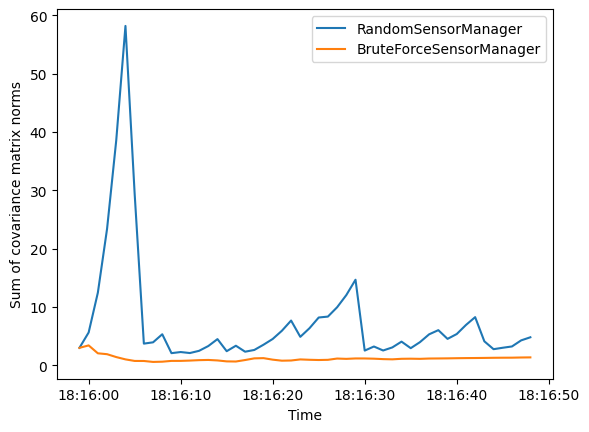

In [11]:
uncertainty_metricA = metricsA['Sum of Covariance Norms Metric']
uncertainty_metricB = metricsB['Sum of Covariance Norms Metric']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([i.timestamp for i in uncertainty_metricA.value],
        [i.value for i in uncertainty_metricA.value],
        label='RandomSensorManager')
ax.plot([i.timestamp for i in uncertainty_metricB.value],
        [i.value for i in uncertainty_metricB.value],
        label='BruteForceSensorManager')
ax.set_ylabel("Sum of covariance matrix norms")
ax.set_xlabel("Time")
ax.legend()